In [1]:
artifacts_dir = '/Users/vinay/Projects/uncertainty-estimates/src/artifacts/'
csv_logs = artifacts_dir+'csvlogs/'

sn = 'mnist_with_sn_1/'
wo_sn = 'mnist_without_sn_1/'

wosn_ckpt = artifacts_dir+'epoch=9-val_loss=0.00.ckpt'
sn_ckpt = artifacts_dir+'epoch=7-val_loss=0.00.ckpt'

#to load models
sn_params = {
    'spectral_normalization': True,
    'mod': False,
    'mnist': True,
    'temp': 1,
    'num_classes': 10
}
params = {
    'spectral_normalization': False,
    'mod': False,
    'mnist': True,
    'temp': 1,
    'num_classes': 10
}

In [2]:
import pandas as pd
metrics_sn = pd.read_csv(csv_logs+sn+'metrics.csv')
metrics = pd.read_csv(csv_logs+wo_sn+'metrics.csv')

In [3]:
metrics_sn[metrics_sn['val_acc']==metrics_sn['val_acc'].max()]

,train_loss,epoch,step,val_acc,train_acc
1814,NaN,7,1799,0.996,NaN


In [4]:
metrics[metrics['val_acc']==metrics['val_acc'].max()]

,train_loss,epoch,step,val_acc,train_acc
2268,NaN,9,2249,0.9974,NaN


In [5]:
# a hack to make notebook work without local package install
import os
import sys
cwd = os.getcwd()
module_path = "/".join(cwd.split('/')[0:-1])
    
if module_path in sys.path:
    print("yes")
    sys.path.remove(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)




Very similar final accuracies.

In [7]:

#loading plane resnet18 model

from src.models import *
from src.run import Model

In [8]:
model = resnet18(**params)

In [9]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
class LitModel(pl.LightningModule):
    def __init__(self,model):
        super().__init__()
        #self.save_hyperparameters(hparams)
        self.model = model

    def forward(self,x):
        x = self.model(x)

In [10]:
ckpt = torch.load(wosn_ckpt)
eval_model = LitModel(model)
eval_model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [56]:
#get data-loaders
data_root = '/'.join(os.getcwd().split('/')[:-1]) + '/data-store'
from src.dataset.loaders import get_loaders

ambmnist = get_loaders(data_root,'train',200,data_type='ambiguousmnist')
fmnist = get_loaders(data_root,'train',200,data_type='fmnist')
mnist_test = get_loaders(data_root,'test',100,data_type='mnist')

num_workers:4
num_workers:4
num_workers:4


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
sample = None
for x,y in fmnist:
    print(x[0].shape)
    print(y)
    sample = x
    #plt.imshow(sample.squeeze(),cmap = plt.cm.gray)
    break

/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


torch.Size([1, 28, 28])
tensor([7, 7, 0, 9, 6, 6, 1, 0, 4, 3, 2, 9, 3, 7, 4, 4, 2, 6, 9, 2, 1, 9, 0, 4,
        2, 2, 4, 1, 1, 0, 0, 1, 0, 2, 5, 1, 1, 8, 7, 4, 8, 0, 2, 4, 1, 4, 8, 2,
        1, 3, 7, 3, 7, 3, 8, 6, 8, 6, 0, 8, 5, 0, 4, 2, 3, 5, 7, 0, 8, 1, 6, 3,
        1, 1, 0, 1, 3, 7, 6, 0, 3, 7, 3, 5, 7, 5, 2, 0, 6, 0, 1, 6, 8, 0, 0, 4,
        6, 3, 9, 3, 1, 5, 9, 3, 1, 1, 3, 1, 9, 3, 4, 4, 8, 4, 0, 2, 4, 4, 0, 8,
        8, 1, 3, 4, 5, 3, 4, 0, 0, 0, 6, 3, 8, 9, 6, 4, 1, 4, 7, 3, 0, 5, 9, 0,
        3, 9, 3, 3, 2, 3, 4, 0, 0, 7, 3, 0, 8, 5, 3, 6, 2, 5, 1, 9, 1, 5, 9, 4,
        9, 1, 5, 5, 9, 2, 5, 2, 4, 0, 0, 1, 7, 3, 5, 6, 3, 1, 8, 4, 0, 8, 9, 5,
        1, 5, 4, 2, 9, 9, 6, 3])


/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [35]:
from src.utils.gmm_utils import get_embeddings, gmm_fit, gmm_evaluate
from src.utils.metrics import *
from tqdm import tqdm

In [50]:
def get_logits (model, data_loader):
    logits = []
    model.eval()
    with torch.no_grad():
        for (data, label) in tqdm(data_loader):
            data = data
            label = label

            output = model(data)
            logits.append(output)
        
    logits = torch.cat(logits, dim=0)
    return logits


def train_gmm(model, num_dim, train_loader, device):
    embeddings, labels = get_embeddings(model,
                                        train_loader,
                                        num_dim,
                                        dtype=torch.double,
                                        device=device,
                                        storage_device=device)
    gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings,
                                          labels=labels,
                                          num_classes=10)
    return gaussians_model


def get_gmm_logits(model, gmm_model, data_loader, device):
    gmm_logits, gmm_labels = gmm_evaluate(model,
                                          gmm_model,
                                          data_loader,
                                          device=device,
                                          num_classes=10,
                                          storage_device=device)
    return gmm_logits

In [51]:
resnet18_wosn_ambimnist_entropies = entropy(get_logits(eval_model.model,ambmnist))

100%|█████████████████████████████████████████| 300/300 [02:37<00:00,  1.91it/s]


In [54]:
resnet18_wosn_fmnist_entropies = entropy(get_logits(eval_model.model,fmnist))

  0%|                                                   | 0/225 [00:00<?, ?it/s]/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|█████████████████████████████████████████| 225/225 [01:58<0

In [57]:
resnet18_wosn_testmnist_entropies = entropy(get_logits(eval_model.model,mnist_test))

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|█████████████████████████████████████████| 100/100 [00:27<0

## See if we can distinguish using entropy distributions alone.

In [58]:
import seaborn as sns

In [65]:
resnet18_wosn_testmnist_entropies = resnet18_wosn_testmnist_entropies.numpy()
resnet18_wosn_fmnist_entropies = resnet18_wosn_fmnist_entropies.numpy()
resnet18_wosn_ambimnist_entropies = resnet18_wosn_ambimnist_entropies.numpy()

In [70]:
resnet18_wosn_testmnist_entropies.min(),resnet18_wosn_testmnist_entropies.max(),resnet18_wosn_testmnist_entropies.mean()

(4.1350827e-08, 1.3168385, 0.0119054215)

In [72]:
resnet18_wosn_ambimnist_entropies.min(),resnet18_wosn_ambimnist_entropies.max(),resnet18_wosn_ambimnist_entropies.mean()

(1.2788486e-06, 1.6961727, 0.25098452)

In [74]:
resnet18_wosn_fmnist_entropies.min(),resnet18_wosn_fmnist_entropies.max(),resnet18_wosn_fmnist_entropies.mean()

(3.3525566e-08, 2.0225267, 0.5061416)

In [80]:
pred_data_class = ['test_mnist']*len(resnet18_wosn_testmnist_entropies)+['ambiguous_mnist']*len(resnet18_wosn_ambimnist_entropies)+['fmnist']*len(resnet18_wosn_fmnist_entropies)

In [85]:
dset = np.concatenate([resnet18_wosn_testmnist_entropies,resnet18_wosn_ambimnist_entropies,resnet18_wosn_fmnist_entropies])

In [88]:
data = pd.DataFrame({'hue':pred_data_class,'entropy':dset})



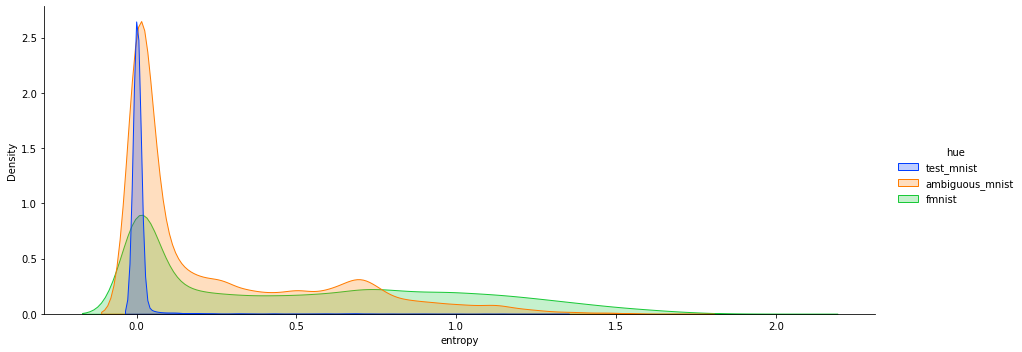

In [92]:
sns.displot(data,hue='hue',x='entropy',kind = 'kde', fill=True,
            palette=sns.color_palette('bright')[:3], height=5, aspect=2.5)

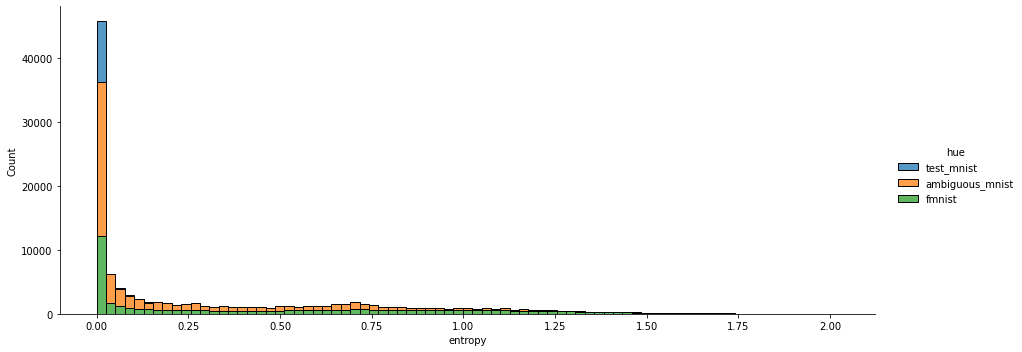

In [93]:
sns.displot(data=data, x="entropy", hue="hue", multiple="stack",height=5, aspect=2.5)

Great deal of overlap. Not good at all

`Note`: **The transition from the final layer to logits seems not to preserve any sort of `input-distribution awareness`,but this information is still latent in the distribution of the lastlayer, which is remarkable. Let's verify this.**

In [101]:
#fit a gaussion model based off train-distribution
mnist_train = get_loaders(data_root,'train',200,data_type='mnist')
resnet18_gmm_model_mnist = train_gmm(eval_model.model, 512, mnist_train, 'cpu')

num_workers:4


  0%|                                                   | 0/225 [00:00<?, ?it/s]/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|█████████████████████████████████████████| 225/225 [02:00<0

In [102]:

resnet18_gmm_model_mnisttest_densities = logsumexp(
    get_gmm_logits(eval_model.model, resnet18_gmm_model_mnist, mnist_test, 'cpu')
)

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|█████████████████████████████████████████| 100/100 [00:28<0

In [103]:

resnet18_gmm_model_fmnisttest_densities = logsumexp(
    get_gmm_logits(eval_model.model, resnet18_gmm_model_mnist, fmnist, 'cpu')
)




  0%|                                                   | 0/225 [00:00<?, ?it/s]/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/vinay/mambaforge/envs/uncertainty-estimates/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|█████████████████████████████████████████| 225/225 [02:00<0

In [104]:

resnet18_gmm_model_ambiguoustest_densities = logsumexp(
    get_gmm_logits(eval_model.model, resnet18_gmm_model_mnist, ambmnist, 'cpu')
)















100%|█████████████████████████████████████████| 300/300 [02:40<00:00,  1.86it/s]


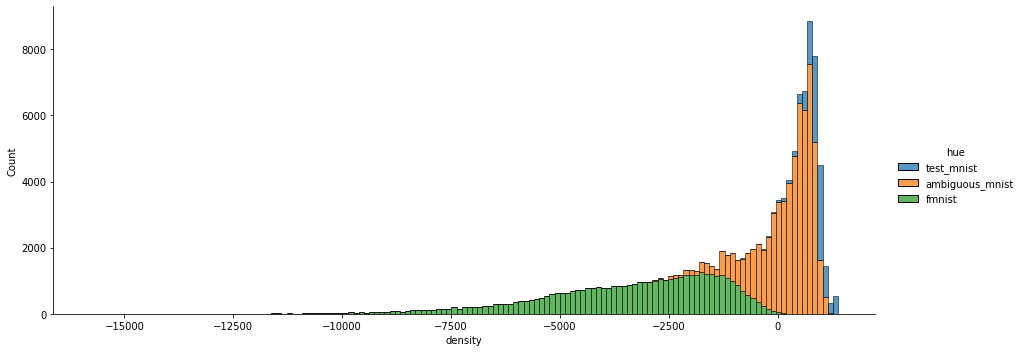

In [105]:
pred_data_class_gmm = ['test_mnist']*len(resnet18_gmm_model_mnisttest_densities)+\
                   ['ambiguous_mnist']*len(resnet18_gmm_model_ambiguoustest_densities)+\
                       ['fmnist']*len(resnet18_gmm_model_fmnisttest_densities)


dset_gmm = np.concatenate([resnet18_gmm_model_mnisttest_densities,resnet18_gmm_model_ambiguoustest_densities,resnet18_gmm_model_fmnisttest_densities])

data_gmm = pd.DataFrame({'hue':pred_data_class_gmm,'density':dset_gmm})

sns.displot(data=data_gmm, x="density", hue="hue", multiple="stack",height=5, aspect=2.5)



`OBSERVATION`:

We can distinguish between out-of-sample and insample pretty-well using this. The hypothesis is once we do this we can use `softmax` entropy to further disentangle between `insample but ambiguous` vs `trustworthy predictions`, thus a complete characterization. Moreover this pipeline can be made much more accurate by using network architectures that doesn't loose global characteristics - you can imagine avg pooling might be a bad idea,in other words we want outputs to be more sensitive to inputs.(to detect ood samples) But this might also be antithesis to generalization,this work offers a pragmatic solution.

- You can use resnet like architecture which in most cases wouldn't sacrifice accuracy but also preserve some sensitivity. 
- Also try adding `spectral norm` if this doesn't also effect you have got a robust and accurate pipeline to detect ood and/or ambiguous samples.
